In [77]:
# pip install -U imbalanced-learn

In [78]:
# !pip install pandas numpy seaborn matplotlib scikit-learn


In [79]:
# !pip install ipykernel --user --upgrade --force-reinstall


In [80]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [81]:
# !pip install openpyxl

In [82]:
# Load the  dataset
file_path = "../data/filtered_fever_data.xlsx"
df = pd.read_excel(file_path)

df.head()

,claim,label
0,Nikolaj Coster-Waldau worked with the Fox Broa...,SUPPORTS
1,Roman Atwood is a content creator.,SUPPORTS
2,"History of art includes architecture, dance, s...",SUPPORTS
3,Adrienne Bailon is an accountant.,REFUTES
4,Homeland is an American television spy thrille...,SUPPORTS


In [83]:
# Preprocess text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text

df["claim"] = df["claim"].apply(clean_text)

# Encode labels
df["label_encoded"] = df["label"].map({
    "SUPPORTS": 0,  # real news
    "REFUTES": 1    # fake news
})

df

,claim,label,label_encoded
0,nikolaj costerwaldau worked with the fox broad...,SUPPORTS,0
1,roman atwood is a content creator,SUPPORTS,0
2,history of art includes architecture dance scu...,SUPPORTS,0
3,adrienne bailon is an accountant,REFUTES,1
4,homeland is an american television spy thrille...,SUPPORTS,0
...,...,...,...
109805,led zeppelin released an eponymous debut album...,REFUTES,1
109806,taal was romantic,SUPPORTS,0
109807,her stars american actress rooney mara,SUPPORTS,0
109808,j r r tolkien created gimli,SUPPORTS,0


In [84]:
X = df['claim']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)

(87848,) (87848,)


In [85]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words="english", max_features=20000, max_df=0.85, min_df=3, norm='l2')

#hypertuning
#max_features = 5000
# vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words="english", max_features=5000, max_df=0.85, min_df=3, norm='l2')
#max_features = 10000
# vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words="english", max_features=10000, max_df=0.85, min_df=3, norm='l2')
#max_features = 30000
# vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words="english", max_features=30000, max_df=0.85, min_df=3, norm='l2')

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [86]:
#reduce class imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.6, random_state=42)  # Increase Fake News cases
undersample = RandomUnderSampler(sampling_strategy=0.8, random_state=42)  # Reduce Real News cases

resample_pipeline = Pipeline([('smote', smote), ('undersample', undersample)])

X_train_tfidf_balanced, y_train_balanced = resample_pipeline.fit_resample(X_train_tfidf, y_train)


In [87]:
from sklearn.svm import LinearSVC

#hypertuning
#C= 0.1
# svm_model = LinearSVC(C=0.1)
#C= 10
# svm_model = LinearSVC(C=10)

svm_model = LinearSVC(C=1.0)
svm_model.fit(X_train_tfidf_balanced, y_train_balanced)
# svm_model.fit(X_train_tfidf, y_train)

LinearSVC()

In [88]:
#cross validation check for overfitting
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_model, X_train_tfidf_balanced, y_train_balanced, cv=5, scoring='f1_macro')
# scores = cross_val_score(svm_model, X_train_tfidf, y_train, cv=5, scoring='f1_macro')
print("5-Fold Cross-Validated F1 Macro:", scores.mean())


5-Fold Cross-Validated F1 Macro: 0.7125150224686815


In [89]:
# 7. Evaluate
y_pred = svm_model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["SUPPORTS", "REFUTES"]))


Accuracy: 0.7102722884983153
Classification Report:

              precision    recall  f1-score   support

    SUPPORTS       0.82      0.78      0.80     16007
     REFUTES       0.47      0.53      0.50      5955

    accuracy                           0.71     21962
   macro avg       0.64      0.66      0.65     21962
weighted avg       0.72      0.71      0.72     21962



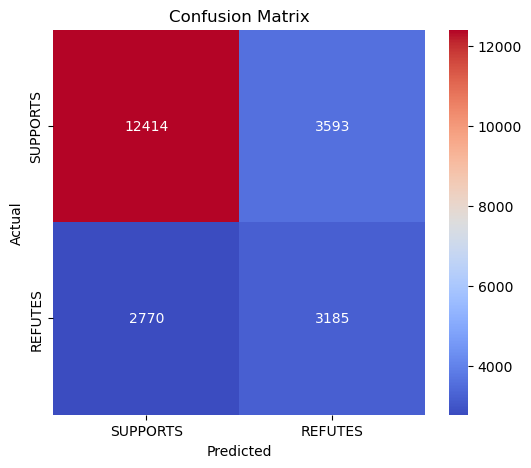

In [90]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=["SUPPORTS", "REFUTES"], yticklabels=["SUPPORTS", "REFUTES"])
plt.ylabel("Actual")
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()

ROC AUC Score: 0.72296


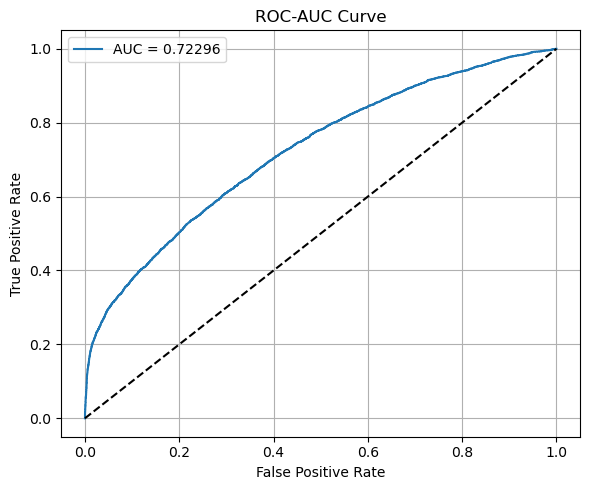

In [91]:
# ROC-AUC Curve
from sklearn.metrics import roc_curve, roc_auc_score


# For SVM: get decision scores instead of predicted labels
y_prob = svm_model.decision_function(X_test_tfidf)

# Calculate FPR, TPR and ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.5f}")

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.5f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


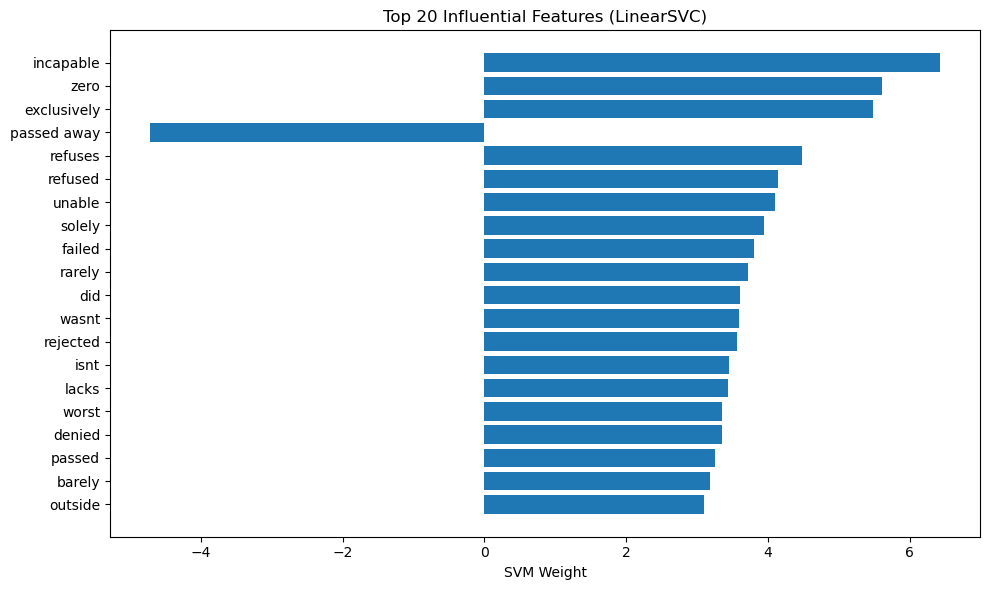

In [92]:
# Get feature names from TF-IDF
feature_names = np.array(vectorizer.get_feature_names_out())

# Get absolute weights from the SVM model
coefs = svm_model.coef_[0]  # shape: (n_features,)
abs_coefs = np.abs(coefs)

# Get indices of top 20 features
top_n = 20
top_indices = np.argsort(abs_coefs)[-top_n:][::-1]  # top 20, descending

# Extract names and scores
top_features = feature_names[top_indices]
top_weights = coefs[top_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_weights, align='center')
plt.yticks(range(top_n), top_features)
plt.gca().invert_yaxis()
plt.xlabel("SVM Weight")
plt.title("Top 20 Influential Features (LinearSVC)")
plt.tight_layout()
plt.show()

In [93]:
def classify_news_article(text, model, vectorizer):
    """
    Classify a news article as REAL (Supported) or FAKE (Refuted) using a trained model and TF-IDF vectorizer.
    
    Parameters:
        text (str): The input news article (string).
        model: Trained classification model (e.g., LinearSVC).
        vectorizer: Trained TfidfVectorizer.
    
    Returns:
        prediction (int): 0 for REAL, 1 for FAKE.
        confidence (float): Distance from decision boundary.
    """
    # Convert article to TF-IDF
    vector = vectorizer.transform([text])
    
    # Predict label
    prediction = model.predict(vector)[0]
    
    # Get decision confidence
    confidence = model.decision_function(vector)[0]
    
    # Human-readable label
    label_map = {0: "REAL (Supported)", 1: "FAKE (Refuted)"}
    
    print(f"Predicted Class: {prediction} => {label_map[prediction]}")
    print(f"Model Confidence (Distance from decision boundary): {confidence:.4f}")
    
    # return prediction, confidence


In [94]:
#real news article
news_article = """
Apple announced a new line of products at its annual event.
The company said that these new devices will significantly enhance user productivity and provide cutting-edge features for daily use.
"""

classify_news_article(news_article, svm_model, vectorizer)


Predicted Class: 0 => REAL (Supported)
Model Confidence (Distance from decision boundary): -0.9690


In [95]:
#fake news article
news_article = """
Scientists Discover a Hidden City Beneath the Sahara Desert!

In an astonishing discovery, a team of archaeologists from an undisclosed research institute has reportedly uncovered the ruins of an ancient civilization beneath the Sahara Desert. Using ground-penetrating radar technology, researchers claim to have identified an extensive network of tunnels, structures, and artifacts dating back over 10,000 years—predating the Egyptian pyramids.

Lead scientist Dr. Marcus Langley stated, "This civilization appears to have been highly advanced, with evidence of an intricate water system and remnants of metal tools that do not match any known historical period."

Satellite images allegedly reveal massive underground chambers, leading to speculation that this lost city may be the true origin of many myths about lost civilizations. However, governments and scientific organizations remain skeptical, urging further investigation before drawing conclusions.

Critics argue that no verifiable evidence has been released, and some experts believe this may be an elaborate hoax or a misinterpretation of natural formations. Nevertheless, conspiracy theorists are already calling this the "Atlantis of the Sahara."

What else could be hidden beneath Earth's shifting sands?
"""
classify_news_article(news_article, svm_model, vectorizer)

Predicted Class: 1 => FAKE (Refuted)
Model Confidence (Distance from decision boundary): 0.6027


In [96]:
# Real news article 
news_article = """
Gaza’s fragile ceasefire shattered early Tuesday as Israel carried out deadly strikes across the enclave and Israeli Prime Minister Benjamin Netanyahu vowed to use “increasing military strength” against Hamas.

The overnight bombardments struck multiple locations across Gaza and were the most extensive since a months-long ceasefire came into effect, with Israel’s Defense Minister Israel Katz declaring: “Tonight we returned to fighting in Gaza.”

The ceasefire deal between Israel and Hamas was already hanging in the balance with phase one ending more than two weeks ago and all sides at loggerheads over a path forward that might see remaining Israeli hostages freed and a permanent peace secured.

Israel’s military and security agency said they were “currently conducting extensive strikes” on Hamas targets in Gaza. In response, Hamas accused Netanyahu of deciding to overturn the ceasefire agreement, and “putting the captives in Gaza at risk of an unknown fate.”

At least 210 people have been killed and hundreds wounded in the new wave of Israeli strikes, according to the Palestinian ministry of health in Gaza.

The Civil Defense in Gaza said a number people were “trapped under the rubble of homes that were bombed in various areas” of the enclave. CNN stringers in Gaza reported the sounds of strikes in multiple locations, including Gaza City, Khan Younis and Deir al-Balah.

Videos obtained by CNN showed scenes of panic and chaos across Gaza as families desperately rushed wounded loved ones to hospital and rescue workers transported patients in ambulances or on stretchers.

Many of the wounded were covered with bloodstained blankets, while others had their limbs wrapped in bloodied bandages.

The images showed several young children killed by the strikes.

Deaths and injuries, including of children, have been reported at hospitals ranging from the northern end of the strip to its southern tip more than 30 kilometers (18 miles) away, including Al-Awda hospital in Tal Al-Zaatar, northern Gaza; Al-Awda hospital in Nuseirat, central Gaza; and Nasser hospital in the southern city of Khan Younis.

Several hospitals said the casualties were due to civilian homes being hit by the strikes.
"""
classify_news_article(news_article, svm_model, vectorizer)


Predicted Class: 0 => REAL (Supported)
Model Confidence (Distance from decision boundary): -2.2945


In [97]:
#dataset real news article 
news_article = """
Sophie Turner acted in The Thirteenth Tale.
"""
classify_news_article(news_article, svm_model, vectorizer)

Predicted Class: 0 => REAL (Supported)
Model Confidence (Distance from decision boundary): -0.2678


In [98]:
#DataSet's Fake news article 
news_article = """
Judy Garland did not appear in a courtroom drama film.
"""
classify_news_article(news_article, svm_model, vectorizer)

Predicted Class: 1 => FAKE (Refuted)
Model Confidence (Distance from decision boundary): 1.3310
